# DTSA 5511 Week 4 Project
### Introduction

The [dataset](https://www.kaggle.com/competitions/nlp-getting-started/overview) to be analyzed is provided via Kaggle and consists of 10000 Twitter messages hand-classified on whether they are about disasters or not.

The goal of the project will be to clean, explore, and encode the data, then train Recurrent Neural Network (RNN) models to perform Natural Language Processing (NLP) to predict the disaster/not disaster labels.

All code for this project can be found on my github: https://github.com/nhansendev/DTSA5511_W4/tree/main

In [17]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

import torch
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
import spacy

from constants import SCRIPT_DIR, RANDOM_SEED
from functions import pad_encode_tensor, encode_KL
from network import train_model, BasicRNNet, get_num_params, plot_model_performance
from cleaning import lem_words, lem_sentences, clean_word

In [ ]:
# Additional Setup

# Draw grid in background
plt.rcParams['axes.axisbelow'] = True

wv_pretrained = api.load('word2vec-google-news-300')

nlp = spacy.load("en_core_web_sm")
nlp_lg = spacy.load("en_core_web_lg")

torch.manual_seed(RANDOM_SEED);

def print2D(values, rows=20, cols=6, just=25):
    for i in range(rows):
        print(''.join([values[i+j*rows].ljust(just) for j in range(cols)]))

### Data Import and Cleaning

In [2]:
# Load Data
train = pd.read_csv(os.path.join(SCRIPT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(SCRIPT_DIR, 'test.csv'))

pd.set_option('display.width', 1000)

print(train.head())
print(train.shape, '\n')

print(test.head())
print(test.shape)

tmp = np.sum(train["target"])
print(f'\nProportion of Disasters: {tmp} of {len(train)} ({tmp/len(train):.1%})')

   id keyword location                                               text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1
(7613, 5) 

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
(3263, 4)

Proportion of Disasters: 3271 of 7613 (43

The structure of the data is:
- "id": a unique identifier for each tweet
- "keyword": a sometimes included keyword from the tweet
- "location": a sometimes included location the tweet was sent from
- "text": the content of the tweet
- "target": whether the tweet is associated with a disaster or not

We can see that there are 7613 tweets in the training dataset and 3263 in the testing dataset.
Approximately 43% of the tweets in the training set are about disasters. A resampling scheme can be used during training to ensure the model is exposed to equal numbers of disaster and non-disaster tweets.

#### Keywords Cleaning
First, the keywords can be explored and cleaned, taking care to address:
- upper and lower case
- non-ascii characters
- punctuation
- URL-style encodings
- double-spaces and tabs

In [3]:
# Keyword cleaning:
tmp = train['keyword'].fillna('nan').str.lower().apply(clean_word).replace("", 'nan')
train.loc[:, 'keyword'] = tmp

tmp = test['keyword'].fillna('nan').str.lower().apply(clean_word).replace("", 'nan')
test.loc[:, 'keyword'] = tmp

unique_keywords, counts = np.unique(train['keyword'].tolist()+test['keyword'].tolist(), return_counts=True)
print(f'Unique Keywords: {len(unique_keywords)}\n')

print2D(unique_keywords, 20, 5, 25)

Unique Keywords: 222

ablaze                   bleeding                 casualties               death                    disaster                 
accident                 blew up                  casualty                 deaths                   displaced                
aftershock               blight                   catastrophe              debris                   drought                  
airplane accident        blizzard                 catastrophic             deluge                   drown                    
ambulance                blood                    chemical emergency       deluged                  drowned                  
annihilated              bloody                   cliff fall               demolish                 drowning                 
annihilation             blown up                 collapse                 demolished               dust storm               
apocalypse               body bag                 collapsed                demolition           

Clearly, some words share a root (e.g. "demolish" and "demolished"), meaning they could be combined. The [WordNetLemmatizer](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html?highlight=wordnet) from NLTK will be used, which references the [WordNet](https://wordnet.princeton.edu/) database (which groups nouns, verbs, adjectives and adverbs "into sets of cognitive synonyms") to find the common roots.

In [4]:
lemmatizer = WordNetLemmatizer()

new_uniques, keyword_map = lem_words(unique_keywords, lemmatizer)

print(f'New Unique Keywords: {len(new_uniques)}\n')

print2D(new_uniques, 20, 6, 25)

New Unique Keywords: 178

ablaze                   bleed                    collide                  detonate                 evacuation               hazard                   
accident                 blight                   collision                detonation               explode                  hazardous                
accident airplane        blizzard                 crash                    devastate                explosion                heat wave                
aftershock               blood                    crush                    devastation              eyewitness               hellfire                 
ambulance                bloody                   curfew                   disaster                 failure structural       hijack                   
annihilate               blow up                  cyclone                  disaster natural         famine                   hijacker                 
annihilation             bomb                     damage            

Due to the presence of multiple terms in some of the keywords (e.g. "forest fire", "natural disaster") it's necessary to split, individually lemmatize, then re-join the terms to ensure the keywords are fully lemmatized, though there is still a limit to what is recognized by the algorithm (e.g. "build burn" != "build on fire" even though they are the same concept).

This results in 178 unique keywords, which can be mapped back to replace the original keywords:

150 scream               100 electrocute          50 wreckage              50 survivor              50 nuclear_reactor       50 hail                  
150 flood                100 destroy              50 wound                 50 stretcher             50 mudslide              50 flatten               
150 drown                100 derail               50 windstorm             50 storm_violent         50 military              50 flame                 
150 bag_body             100 demolish             50 wind                  50 storm                 50 meltdown              50 first_responder       
142 bomb                 100 deluge               50 wildfire              50 snowstorm             50 mayhem                50 fire_wild             
100 wreck                100 death                50 whirlwind             50 smoke                 50 massacre              50 fire_truck            
100 weapon               100 crush                50 upheaval              50 sinkhole        

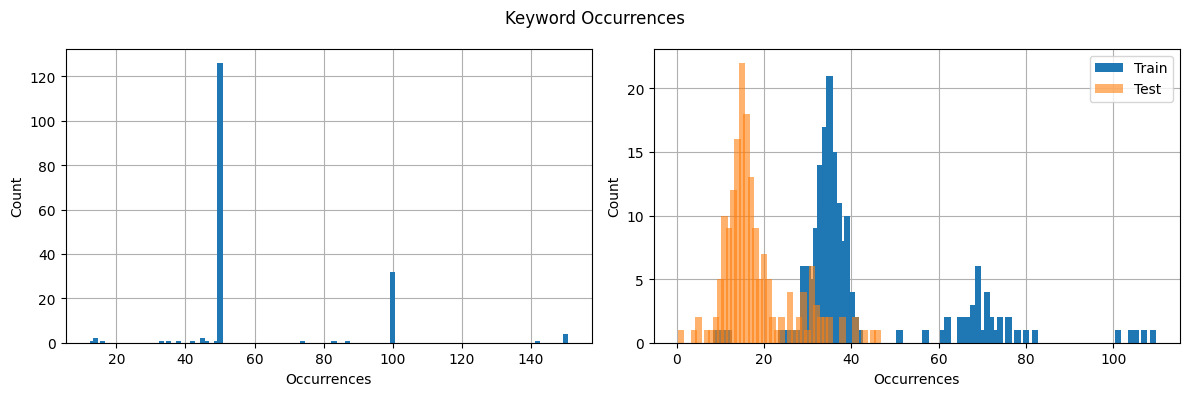

In [5]:
# Replace keywords
train_keyclean = train.copy(deep=True)
train_keyclean.loc[:, 'keyword'] = train['keyword'].replace(keyword_map).str.replace(" ", "_")

test_keyclean = test.copy(deep=True)
test_keyclean.loc[:, 'keyword'] = test['keyword'].replace(keyword_map).str.replace(" ", "_")

# Get counts of all keyword occurrences
uniques, counts = np.unique(train_keyclean['keyword'].tolist()+test_keyclean['keyword'].tolist(), return_counts=True)

tmp = list(zip(counts, uniques))
tmp.sort(reverse=True)
SC, SU = list(zip(*tmp))

# Print occurrence count and keyword pairs
print2D([f'{SC[i]} {SU[i]}' for i in range(len(SC))])

# Get counts of keyword counts
vals, cnts = np.unique(counts, return_counts=True)

fig, ax = plt.subplots(1, 2)
axs = fig.axes

fig.set_size_inches(12, 4)

axs[0].bar(vals, cnts, width=1.5)

uniques, counts = np.unique(train_keyclean['keyword'].tolist(), return_counts=True)
vals, cnts = np.unique(counts, return_counts=True)
axs[1].bar(vals, cnts, width=1.5)

uniques, counts = np.unique(test_keyclean['keyword'].tolist(), return_counts=True)
vals, cnts = np.unique(counts, return_counts=True)
axs[1].bar(vals, cnts, width=1.5, alpha=0.6)

axs[1].legend(['Train', 'Test'])

for a in axs:
    a.set_xlabel('Occurrences')
    a.set_ylabel('Count')
    a.grid()

plt.suptitle('Keyword Occurrences')
plt.tight_layout()
plt.show()

Surprisingly, we can see that most keywords appear exactly 50, 100, or 150 times in the dataset (totals across both testing and training sets). Given the uneven distribution it may be beneficial to implement a sampling scheme that tries to sample keywords uniformly.

For compatability with the encoding process, all spaces will be replaced with underscores.

Qty of nan: 61


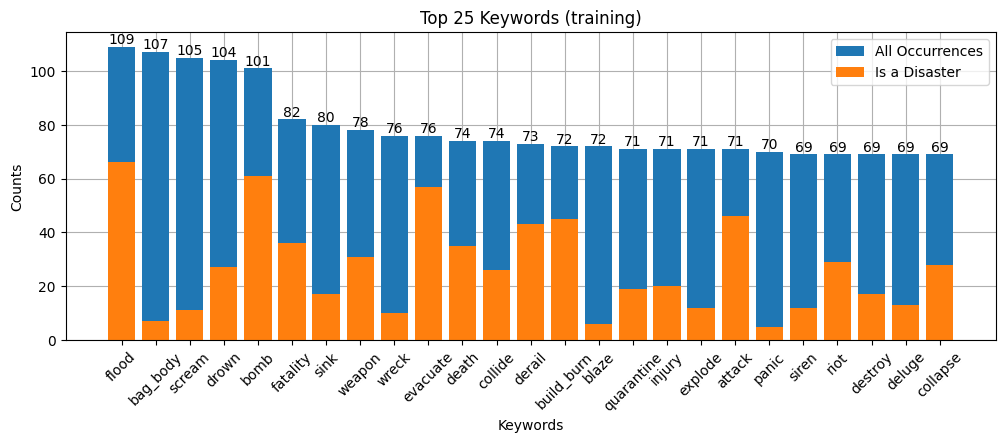

In [6]:
# Plot keywords vs disastor or non disaster
uniques, counts = np.unique(train_keyclean['keyword'], return_counts=True)
tmp = list(zip(counts, uniques))
tmp.sort(reverse=True)

C, U = list(zip(*tmp[:25]))

# Count disasters
target_counts = []
for word in U:
    target_counts.append(np.sum(train_keyclean['target'][train_keyclean['keyword'] == word]))

print("Qty of nan:", np.sum(train_keyclean['keyword'] == 'nan'))

B = plt.bar(U, C)
plt.bar(U, target_counts)
plt.gcf().set_size_inches(12, 4)
plt.bar_label(B, C)
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.xlabel('Keywords')
plt.title('Top 25 Keywords (training)')
plt.legend(['All Occurrences', 'Is a Disaster'])
plt.grid()
plt.show()

The 25 most frequent keywords are shown, as well as the number of their occurrences that are labeled as a disaster. Some, like "attack" and "evacuate" are frequently associated with disasters, while others like "body bag" and "blaze" are not. This suggests that the keywords will be useful for training the model.

#### Locations Cleaning
Repeating the process for locations:

In [7]:
# Location cleaning
tmp = train_keyclean['location'].fillna('nan').str.lower().apply(clean_word).replace("", 'nan')
train_clean = train_keyclean.copy(deep=True)
train_clean.loc[:, 'location'] = tmp

tmp = test_keyclean['location'].fillna('nan').str.lower().apply(clean_word).replace("", 'nan')
test_clean = test_keyclean.copy(deep=True)
test_clean.loc[:, 'location'] = tmp

unique_locations, counts = np.unique(train_clean['location'].tolist()+test_clean['location'].tolist(), return_counts=True)
print(f'Unique Locations: {len(unique_locations)}\n')

print2D(unique_locations, 20, 4, 35)

Unique Locations: 4068

05042014 1823                      17th dimension                     261 5th avenue new york ny         3rd eye chakra                     
1 vacation destinationhawaii       18 509                             2870967297376514                   3rd terrestrial planet sun         
10 hours from pluto                18 cc                              2b hindhede rd singapore           401 livin                          
10 steps ahead cloud 9             1937 germany                       3000 miles from everyone           408 n western wenatchee wa         
10718 79th street                  19600858 99047821                  301804                             412 nw 5th ave portland or         
10jul                              1996                               302                                424 n fairfax ave 90036            
110 taron squad                    1d 5sos ag                         302 815                            434                      

Printing a few examples of the 4068 unique locations demonstrates how many of the values are not easily recognizable as a location, often containing seemingly random numbers, jokes and dates.

Given the large number of uniques there must be many locations that are rarely re-used. Looking at the number of "Word Occurrences" (how many times total a location appears) and their counts:

186


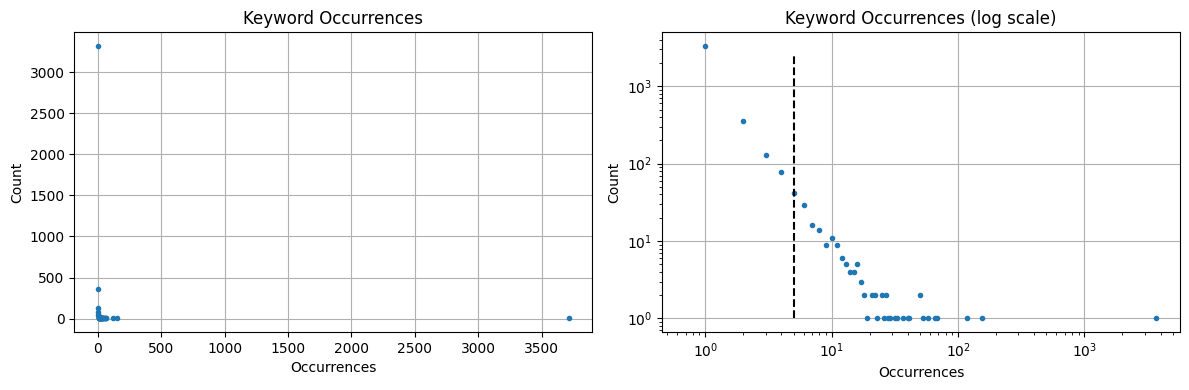

In [8]:
vals, cnts = np.unique(counts, return_counts=True)

# Track which locations occurrences
nanmap = {}
freq_locs = []
for i in range(len(unique_locations)):
    if counts[i] >= 5:
        # Add to the list of kept locations
        freq_locs.append([counts[i], unique_locations[i]])
    else:
        # Add to the map of locations to drop (replace with 'nan')
        nanmap[unique_locations[i]] = 'nan'

freq_locs.sort(reverse=True)

print(len(freq_locs))

fig, ax = plt.subplots(1, 2)
axs = fig.axes
fig.set_size_inches(12, 4)

axs[0].plot(vals, cnts, '.')
axs[1].plot(vals, cnts, '.')

axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].vlines(5, 1, 2500, linestyles='dashed', color='k')

axs[0].set_title('Keyword Occurrences')
axs[1].set_title('Keyword Occurrences (log scale)')

for a in axs:
    a.set_xlabel('Occurrences')
    a.set_ylabel('Count')
    a.grid()

plt.tight_layout()
plt.show()

We can see that approximately 3500 of the unique locations occur exactly once, with most occurring less than 11 times. If a threshold of at least 5 occurrences is required, then the 4068 unique values are reduced to just 186.

In [9]:
C, L = list(zip(*freq_locs))

# Print occurrence count and location pairs
print2D([f'{C[i]} {L[i]}' for i in range(len(C))], just=34)

3714 nan                          25 new york ny                    15 atlanta ga                     11 lagos                          9 phoenix az                      7 toronto ontario                 
154 usa                           23 san francisco                  14 sydney australia               11 england                        9 massachusetts                   7 tennessee                       
117 new york                      22 everywhere                     14 nashville tn                   11 calgary alberta                9 las vegas                       7 tampa fl                        
68 london                         22 california usa                 14 houston tx                     11 austin tx                      9 lagos nigeria                   7 san diego                       
66 united states                  21 san francisco ca               14 denver colorado                11 304                            9 brooklyn ny                     7 puerto r

When comparing the names we can see clear overlaps, such as "us", "usa", and "united states". However, since no robust method was found capable of resolving these overlaps automatically they will be allowed to remain in the dataset as-is.

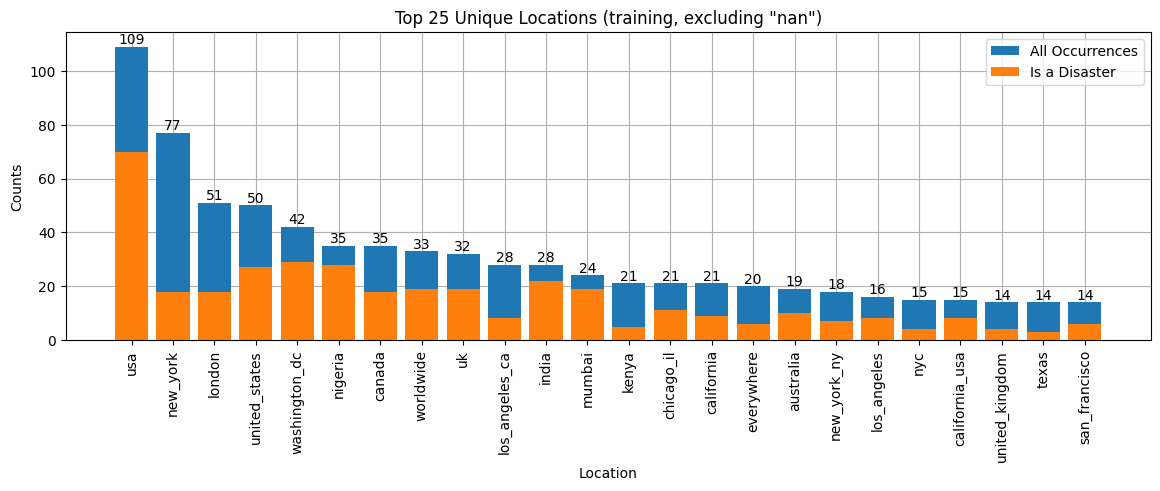

In [10]:
# Replace infrequent locations with 'nan'
train_clean.loc[:, 'location'] = train_clean['location'].replace(nanmap).str.replace(" ", "_")
test_clean.loc[:, 'location'] = test_clean['location'].replace(nanmap).str.replace(" ", "_")

# Get unique counts
uniques, counts = np.unique(train_clean['location'], return_counts=True)
tmp = list(zip(counts, uniques))
tmp.sort(reverse=True)

C, L = list(zip(*tmp[:25]))

# Get the number of disasters for each location
target_counts = []
loc_counts = []
for word in L:
    target_counts.append(np.sum(train_clean['target'][train_clean['location'] == word]))
    loc_counts.append(np.sum(train_clean['location'] == word))

# Plot top 25 locations, excluding 'nan's
B = plt.bar(L[1:26], loc_counts[1:26])
plt.bar(L[1:26], target_counts[1:26])
plt.gcf().set_size_inches(14, 4)
plt.bar_label(B, loc_counts[1:26])
plt.xticks(rotation=90)
plt.ylabel('Counts')
plt.xlabel('Location')
plt.title('Top 25 Unique Locations (training, excluding "nan")')
plt.legend(['All Occurrences', 'Is a Disaster'])
plt.grid()
plt.show()

Unlike the initial sample of the 4068 unique locations, the top 25 cleaned locations are all clearly recognizable as real-life places.

#### Text (Tweet) Cleaning
Next, the text itself must be cleaned:

In [11]:
# Remove stop-words and non-alphanumeric characters, then lemmatize everything
stop_words = stopwords.words('english')

lems_train = lem_sentences(train_clean['text'].str.lower(), stop_words, lemmatizer)
lems_test = lem_sentences(test_clean['text'].str.lower(), stop_words, lemmatizer)

for L in lems_train[:5]:
    print(L)

['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']
['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
['resident', 'ask', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect']
['people', 'receive', 'wildfire', 'evacuation', 'order', 'california']
['get', 'send', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pour', 'school']


The sentences have been made more compact, containing only the necessary words to provide context, and with words converted via lemmatization to be as common as possible. Ideally this will make model training easier by removing "noise" from the data.

#### Resampling
As noted before, there are heavy imbalances between keyword and location occurrences, as well as a small imbalance between disaster and non-disaster tweets. Since there are multiple of these factors to consider, a probabalistic resampling scheme was devised with sampling frequency inversely proportional to number of dataset occurrences.

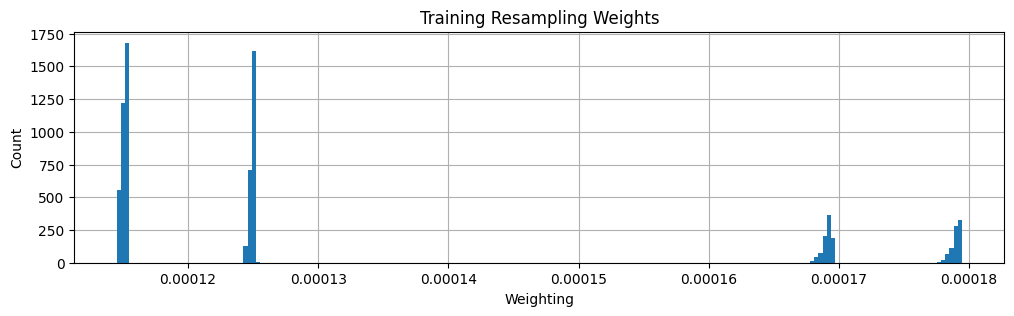

In [12]:
# Create maps between unique values and their frequencies in the dataset
N = len(train_clean)

unique_labels, label_counts = np.unique(train_clean['target'], return_counts=True)
unique_keywords, keyword_counts = np.unique(train_clean['keyword'], return_counts=True)
unique_locations, location_counts = np.unique(train_clean['location'], return_counts=True)

label_map = {unique_labels[i]: label_counts[i]/N for i in range(len(unique_labels))}
keyword_map = {unique_keywords[i]: keyword_counts[i]/N for i in range(len(unique_keywords))}
location_map = {unique_locations[i]: location_counts[i]/N for i in range(len(unique_locations))}

# Use the maps to assign inverse combined weightings for each row
weights = []
for i, row in train_clean.iterrows():
    weights.append(1-(label_map[row['target']]+keyword_map[row['keyword']]+location_map[row['location']])/3)

# Normalize weights
resampling_weights = np.array(weights)/np.sum(weights)

plt.hist(resampling_weights, 200)
plt.xlabel('Weighting')
plt.ylabel('Count')
plt.title('Training Resampling Weights')
plt.gcf().set_size_inches(12, 3)
plt.grid()
plt.show()

The "clustered" appearance of the weights histogram reflects the categorical format of the data, with many of the possible categories having similar frequencies in the dataset.

#### Text Encoding

Next the words must be converted to a numeric representation. Four encoders will be compared: [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) from Gensim (not pre-trained, and pre-trained on Google News), as well as "en_core_web_sm", and "en_core_web_lg" from [spaCy](https://spacy.io/models/en). 

The Word2Vec encoder uses a shallow neural network to embed words into a configurable vector-space, where words with similar, context-sensitive meaning will be grouped closer together. The non pre-trained encoder will be fit to all of the sentences, keywords, and locations in the dataset. Any words that the encoder was not fit-to will produce an error during encoding, which will be handled using a vector of zeros for that word. One caveat is that the size of the dataset (10,000 tweets) might be too small to properly train the model.

For comparison, two pre-trained models from spaCy will also be evaluated, which make use of "a MultiHashEmbed embedding layer that uses subword features, and a MaxoutWindowEncoder encoding layer consisting of a CNN and a layer-normalized maxout activation function" per the [documentation](https://spacy.io/api/architectures#HashEmbedCNN).

In [13]:
# Gensim Word to Vector Encoding
sentences = lems_train+lems_test+[[a] for a in train_clean['keyword'].tolist()+train_clean['location'].tolist()+test_clean['keyword'].tolist()+test_clean['location'].tolist()]

# Train encoder
word_encoder = Word2Vec(vector_size=96, sentences=sentences, min_count=1, seed=RANDOM_SEED).wv
print("Vocabulary:", len(word_encoder.key_to_index), 'words\n')

Vocabulary: 15702 words



Generate encoded datasets using each encoder:

In [14]:
N = 5
# Prepare Gensim Encoded Data
# 96-dimensional encoding
print(f"1 of {N}")
train_sentences_encoded, train_sens_lens = pad_encode_tensor(lems_train, word_encoder=word_encoder)
test_sentences_encoded, test_sens_lens = pad_encode_tensor(lems_test, word_encoder=word_encoder)

train_KL_encoded = encode_KL(train_clean, word_encoder=word_encoder)
test_KL_encoded = encode_KL(test_clean, word_encoder=word_encoder)

# Prepare Gensim (Pre-Trained) Encoded Data
# 300-dimensional encoding
print(f"2 of {N}")
train_sentences_encoded_pre, _ = pad_encode_tensor(lems_train, 300, word_encoder=wv_pretrained)
test_sentences_encoded_pre, _ = pad_encode_tensor(lems_test, 300, word_encoder=wv_pretrained)

train_KL_encoded_pre = encode_KL(train_clean, 300, word_encoder=wv_pretrained)
test_KL_encoded_pre = encode_KL(test_clean, 300, word_encoder=wv_pretrained)

# Prepare Gensim (Pre-Trained) Encoded Data - No Text Cleaning
# 300-dimensional encoding
print(f"3 of {N}")
train_sentences_encoded_nolem, _ = pad_encode_tensor(train_clean['text'], 300, word_encoder=wv_pretrained)
test_sentences_encoded_nolem, _ = pad_encode_tensor(test_clean['text'], 300, word_encoder=wv_pretrained)

# Prepare spaCy (Pre-Trained, Small) Encoded Data
# (96-dimensional encoding, "en_core_web_sm" model)
print(f"4 of {N}")
train_sentences_encoded_spc, _ = pad_encode_tensor(lems_train, nlp=nlp)
test_sentences_encoded_spc, _ = pad_encode_tensor(lems_test, nlp=nlp)

train_KL_encoded_spc = encode_KL(train_clean, nlp=nlp)
test_KL_encoded_spc = encode_KL(test_clean, nlp=nlp)

# Prepare spaCy (Pre-Trained, Large) Encoded Data
# (300-dimensional encoding, "en_core_web_lg" model)
print(f"5 of {N}")
train_sentences_encoded_spc_lg, _ = pad_encode_tensor(lems_train, 300, nlp=nlp_lg)
test_sentences_encoded_spc_lg, _ = pad_encode_tensor(lems_test, 300, nlp=nlp_lg)

train_KL_encoded_spc_lg = encode_KL(train_clean, 300, nlp=nlp_lg)
test_KL_encoded_spc_lg = encode_KL(test_clean, 300, nlp=nlp_lg)

1 of 5
2 of 5
3 of 5
4 of 5
5 of 5


### Model Training

Eight configurations will be trained to explore various combinations of encoders, model types, text cleaning, and resampling:
|  #| Model      | Encoder | Encoder Pre-Training   | Data             |
|---|------------|---------|----------------|------------------|
| 1 | LSTM       | Gensim  | Our dataset           | Base             |
| 2 | LSTM       | Gensim  | Google News    | Base             |
| 3 | LSTM       | Gensim  | Google News    | Resampled        |
| 4 | LSTM       | Gensim  | Google News    | No Text Cleaning |
| 5 | LSTM       | spaCy   | en_core_web_sm | Base             |
| 6 | Large LSTM | spaCy   | en_core_web_sm | Base             |
| 7 | LSTM       | spaCy   | en_core_web_lg | Base             |
| 8 | GRU        | spaCy   | en_core_web_sm | Base             |

Models will be trained on the GPU instead of the CPU for a substantial improvement in speed.

Each model has the same basic architecture: a recurrent head and a dense head, which process the sentences and combined keywords and locations, respectively. The outputs of these heads are combined via additional dense layers to get the final output.

<div>
<img src="Snap4.png" width="500"/>
</div>

In [36]:
# Split data for training and validation
train_idxs, valid_idxs = train_test_split(list(range(len(lems_train))), train_size=0.8, random_state=RANDOM_SEED)

# Get and normalize relevant resampling weights
train_resample_weights = resampling_weights[train_idxs]
train_resample_weights /= np.sum(train_resample_weights)

train_targets = torch.FloatTensor(train_clean['target']).unsqueeze(1).cuda()

valid_scores = np.zeros(8)
model_params = np.zeros(8)

In [38]:
def test_predictions_to_file(model, IDs, test_encoded_sentences, test_KL_encoded, length_indexes, filename):
    # Generate outputs for Kaggle
    with torch.no_grad():
        model.eval()
        preds = (
            model(
                test_encoded_sentences,
                test_KL_encoded,
                length_indexes
            )
            .cpu().numpy()
            >= 0.5
        ).astype(int)

    df = pd.DataFrame()
    df['id'] = IDs
    df['target'] = preds

    df.to_csv(os.path.join(SCRIPT_DIR, filename), index=False)


def model_cleanup():
    # To free memory on the GPU
    global model
    model.cpu()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
torch.cuda.empty_cache()

BATCH = 256
LR = 0.0001
pidx = 0

#### 1) LSTM, Gensim

In [39]:
# Initialize LSTM-based model and transfer to GPU
model = BasicRNNet(96, 50, 30).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded, train_KL_encoded, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 10000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded, test_KL_encoded, test_sens_lens, "pred1.csv")

Parameters: 119141
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(96, 50, num_layers=5, batch_first=True)
    (L2): Linear(in_features=50, out_features=30, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=192, out_features=30, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=60, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:50<00:00, 199.32it/s]


Validation F1 Score: 0.550


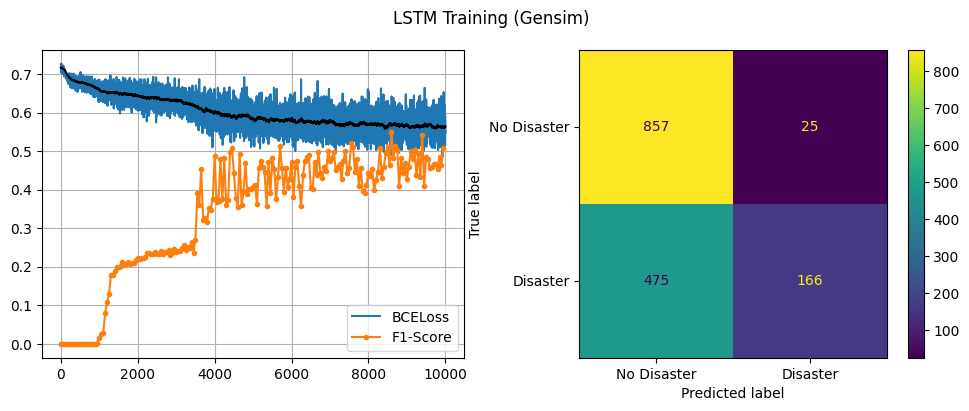

In [40]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded, train_KL_encoded, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (Gensim)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 2) LSTM, Gensim Pretrained

In [41]:
model = BasicRNNet(300, 100, 50).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_pre, train_KL_encoded_pre, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 3000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_pre, test_KL_encoded_pre, test_sens_lens, "pred2.csv")

Parameters: 520121
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(300, 100, num_layers=5, batch_first=True)
    (L2): Linear(in_features=100, out_features=50, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=600, out_features=50, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [00:18<00:00, 161.46it/s]


Validation F1 Score: 0.740


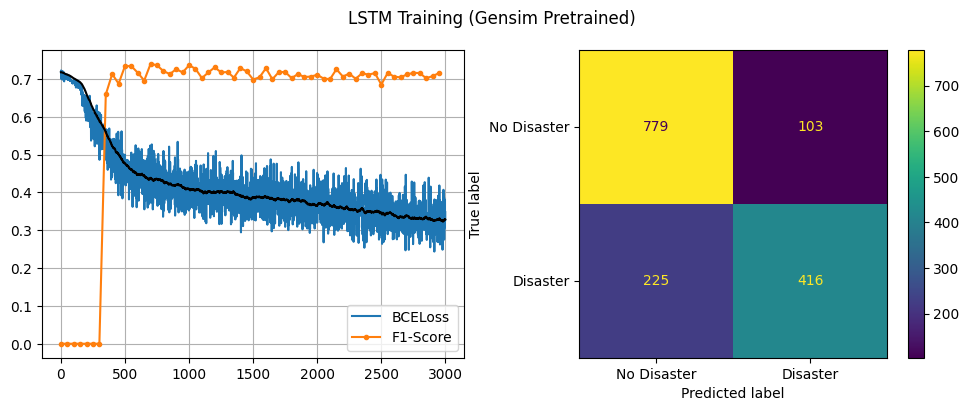

In [42]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_pre, train_KL_encoded_pre, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (Gensim Pretrained)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 3) LSTM, Gensim Pretrained, with Resampling

In [43]:
model = BasicRNNet(300, 100, 50).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_pre, train_KL_encoded_pre, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, train_resample_weights, 3000, batch_size=256, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_pre, test_KL_encoded_pre, test_sens_lens, "pred3.csv")

Parameters: 520121
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(300, 100, num_layers=5, batch_first=True)
    (L2): Linear(in_features=100, out_features=50, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=600, out_features=50, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [00:18<00:00, 159.58it/s]


Validation F1 Score: 0.754


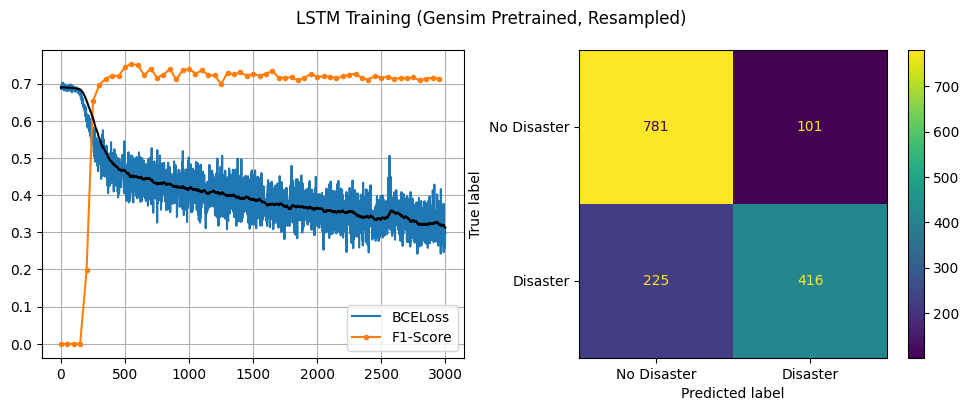

In [44]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_pre, train_KL_encoded_pre, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (Gensim Pretrained, Resampled)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 4) LSTM, Gensim Pretrained, No Text Cleaning

In [45]:
model = BasicRNNet(300, 100, 50).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_nolem, train_KL_encoded_pre, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 6000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_nolem, test_KL_encoded_pre, test_sens_lens, "pred4.csv")

Parameters: 520121
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(300, 100, num_layers=5, batch_first=True)
    (L2): Linear(in_features=100, out_features=50, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=600, out_features=50, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 6000/6000 [02:16<00:00, 43.80it/s]


Validation F1 Score: 0.611


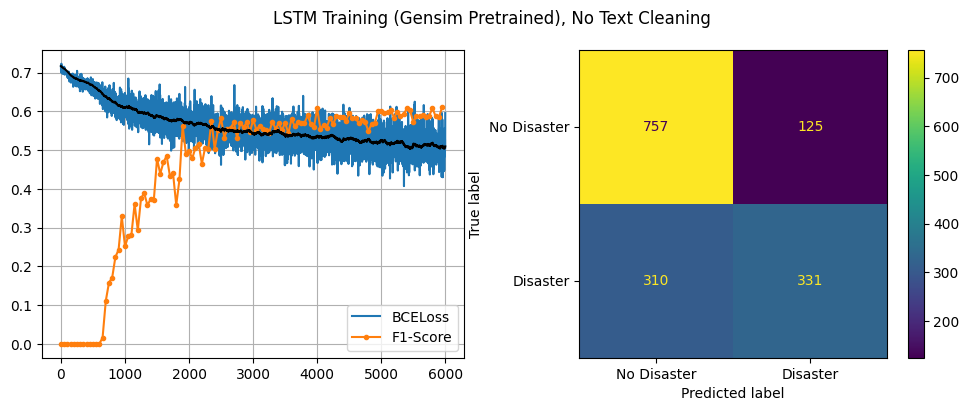

In [46]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_nolem, train_KL_encoded_pre, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (Gensim Pretrained), No Text Cleaning')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 5) LSTM, spaCy SM

In [47]:
model = BasicRNNet(96, 50, 30).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 3000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_spc, test_KL_encoded_spc, test_sens_lens, "pred5.csv")

Parameters: 119141
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(96, 50, num_layers=5, batch_first=True)
    (L2): Linear(in_features=50, out_features=30, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=192, out_features=30, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=60, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [00:15<00:00, 198.93it/s]


Validation F1 Score: 0.646


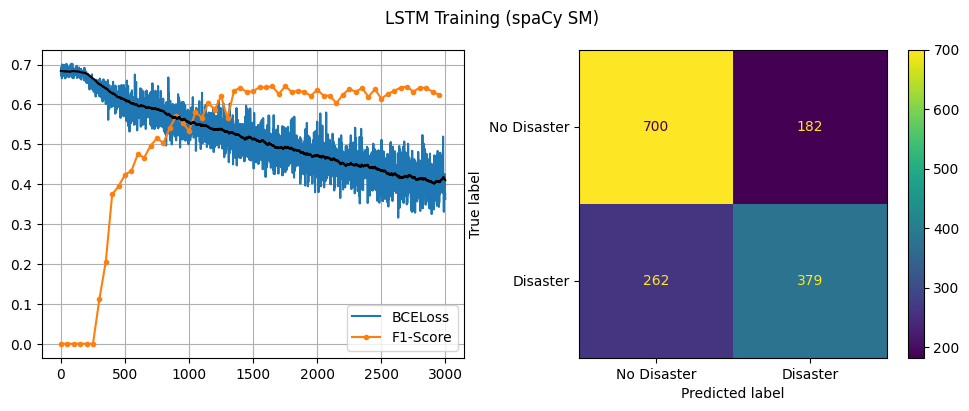

In [48]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (spaCy SM)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 6) LSTM Large, spaCy SM

In [53]:
model = BasicRNNet(96, 150, 80, rnn_layers=8).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 3000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_spc, test_KL_encoded_spc, test_sens_lens, "pred6.csv")

Parameters: 1446341
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(96, 150, num_layers=8, batch_first=True)
    (L2): Linear(in_features=150, out_features=80, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=192, out_features=80, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=160, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [01:48<00:00, 27.76it/s]


Validation F1 Score: 0.650


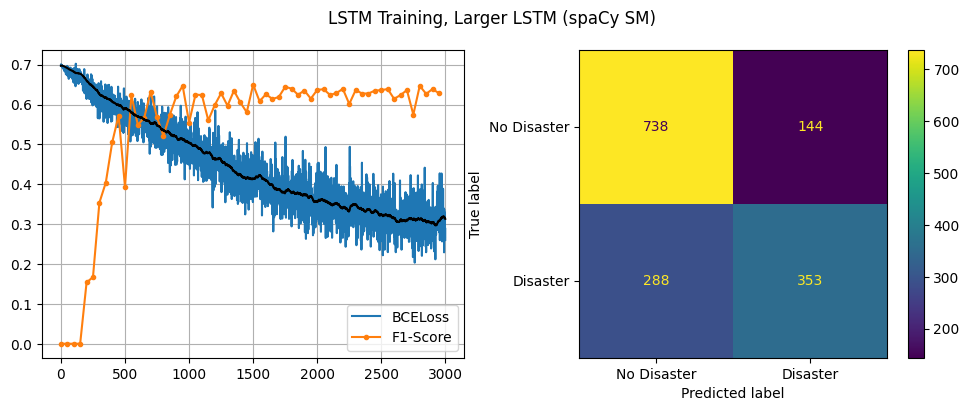

In [54]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training, Larger LSTM (spaCy SM)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 7) LSTM, spaCy LG

In [55]:
model = BasicRNNet(300, 100, 50).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_spc_lg, train_KL_encoded_spc_lg, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 3000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_spc_lg, test_KL_encoded_spc_lg, test_sens_lens, "pred7.csv")

Parameters: 520121
BasicRNNet(
  (RNN_head): LSTM_Head(
    (L1): LSTM(300, 100, num_layers=5, batch_first=True)
    (L2): Linear(in_features=100, out_features=50, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=600, out_features=50, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [00:19<00:00, 150.34it/s]


Validation F1 Score: 0.760


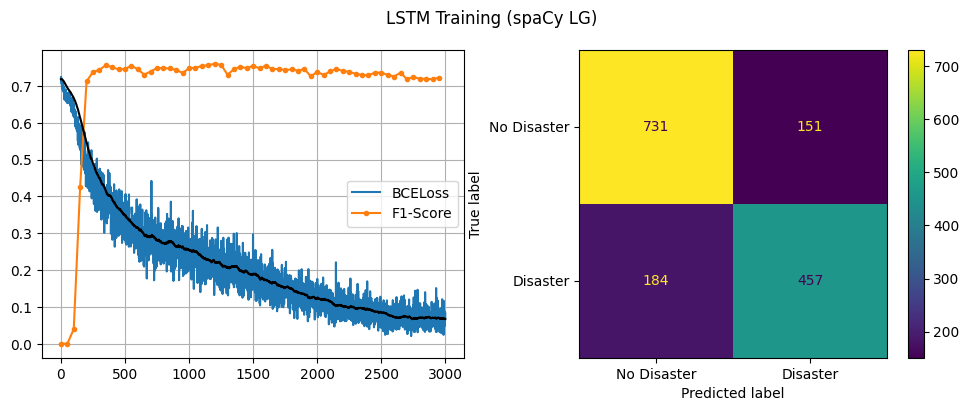

In [56]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_spc_lg, train_KL_encoded_spc_lg, train_sens_lens, train_clean['target'], valid_idxs, title='LSTM Training (spaCy LG)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

#### 8) GRU, spaCy SM

In [57]:
model = BasicRNNet(96, 50, 30, use_LSTM=False).cuda()

params = get_num_params(model)
model_params[pidx] = params
print("Parameters:", params)
print(model)

model, loss_hist, valid_hist = train_model(model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_targets, train_clean['target'], train_idxs, valid_idxs, None, 3000, batch_size=BATCH, lr=LR)

test_predictions_to_file(model, test['id'], test_sentences_encoded_spc, test_KL_encoded_spc, test_sens_lens, "pred8.csv")

Parameters: 91341
BasicRNNet(
  (RNN_head): GRU_Head(
    (L1): GRU(96, 50, num_layers=5, batch_first=True)
    (L2): Linear(in_features=50, out_features=30, bias=True)
    (act): Hardswish()
    (drop): Dropout(p=0.3, inplace=False)
  )
  (Dense_head): Sequential(
    (0): Linear(in_features=192, out_features=30, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out_net): Sequential(
    (0): Linear(in_features=60, out_features=10, bias=True)
    (1): Hardswish()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


100%|██████████| 3000/3000 [00:14<00:00, 210.63it/s]


Validation F1 Score: 0.651


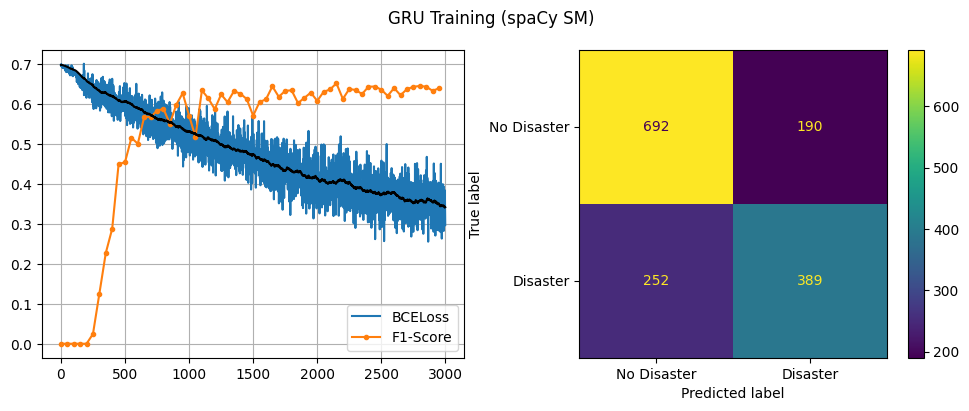

In [58]:
score = plot_model_performance(loss_hist, valid_hist, model, train_sentences_encoded_spc, train_KL_encoded_spc, train_sens_lens, train_clean['target'], valid_idxs, title='GRU Training (spaCy SM)')
valid_scores[pidx] = score
pidx += 1

model_cleanup()

### Results

Predictions on the test sets were generated for each run and uploaded to Kaggle, with the resulting scores in the "F1 Test" column in the results table:

In [62]:
# Results Table
df = pd.DataFrame()
df['Model'] = ['LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'LSTM', 'GRU']
df['Data'] = ['Base', 'Base', 'Resample', 'No Clean', 'Base', 'Base', 'Base', 'Base']
df['Encoder'] = ['Gensim', 'Gensim Pretrain', 'Gensim Pretrain',  'Gensim Pretrain', 'spaCy SM', 'spaCy SM', 'spaCy LG', 'spaCy SM']
df['Parameters'] = model_params.astype(int)
df['F1 Valid'] = valid_scores.round(3)
df['F1 Test'] = [0.682, 0.781, 0.772, 0.705, 0.704, 0.712, 0.762, 0.699]

df

,Model,Data,Encoder,Parameters,F1 Valid,F1 Test
0,LSTM,Base,Gensim,119141,0.550,0.682
1,LSTM,Base,Gensim Pretrain,520121,0.740,0.781
2,LSTM,Resample,Gensim Pretrain,520121,0.754,0.772
3,LSTM,No Clean,Gensim Pretrain,520121,0.611,0.705
4,LSTM,Base,spaCy SM,119141,0.646,0.704
5,LSTM,Base,spaCy SM,1446341,0.650,0.712
6,LSTM,Base,spaCy LG,520121,0.760,0.762
7,GRU,Base,spaCy SM,91341,0.651,0.699


Some observations from the results:
- The worst performing model used the Gensim encoder trained on the 10000 dataset sentences (15702 words)
- The best performing model used the Google News pre-trained Gensim encoder (3 million words and phrases)
- Re-sampling was beneficial to the validation score, but not the test score
- Cleaning the text before passing it to the encoder substantially improved both scores
- The more complex architecture of the spaCy encoders did not improve on the test score compared to the pre-trained Gensim
- Making the LSTM model wider and deeper (~10x more parameters) only had a small improvement on scores
    - This suggests that further improvements would require a different model architecture
- Using GRU instead of LSTM as the RNN had minimal impact on the scores, but required fewer parameters
    - Given the relatively short sentences the advantages of LSTM's longer memory may be less evident

### Conclusion

The goal of this project was to create RNN-based NLP models capable of predicting whether the topic of twitter messages related to a disaster or not.

Various model, encoder, cleaning, and sampling combinations were compared, resulting in the best combination's F1-score of 0.781.

Of the tested combinations it was found that the choice of encoder and the use of data cleaning had the largest effect on score.

Additional areas that could be explored include:
- Different neural network model architectures instead of the two-headed approach
- Batch-normalization regularization
- Additional advanced, pre-trained encoders, such as BERT and GloVe
- Learning rate scheduling

### References

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

Model Architectures · SPACY API Documentation. (n.d.). Model Architectures. https://spacy.io/api/architectures#HashEmbedCNN

Gensim: topic modelling for humans. (n.d.). https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

LSTM — PyTorch 2.4 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html